# Машинное обучение 2021, часть 1, семинар 12. Градиентный бустинг

## Градиентный бустинг

![](https://miro.medium.com/max/1024/0*6iP5_GhicmoijUu-.png)

#### Аддативное моделирование

Предположим, у нас есть некоторая неизвестная зависимость:

![](https://explained.ai/gradient-boosting/images/L2-loss/L2-loss_additive_2.svg)

Предположим, что она состоит из суммы нескольких более простых функций. Как бы нам их отгадать?

Раз при $x=0$ получается, что $y=30$, в качестве первой функции возьмём $f(x)=30$.

Также мы видим, что у нас наша зависимость наклонена относительно оси $Ox$, поэтому неплохая догадка - это функция $f(x)=y$

А при виде волнистости мы обычно вспоминаем $f(x)=\sin x$

В итоге если сложить всё вместе, то получится исходная функция. Как удачно!

![](https://explained.ai/gradient-boosting/images/L2-loss/L2-loss_additive_3.svg)

То есть мы приблизили неизвестную нам функцию с помощью суммы других, более простых, функций, т.е.
$$
F(x) = \sum\limits_{i=0}^mf_m(x)
$$

А в машинном обучении мы как раз по данным и хотим неизвестную функцию зависимости восстановить. Градиентный бустинг делает это как раз с помощью аддитивного моделирования.

#### Бустинг

Бустинг -- это когда мы на каждом шаге выбираем алгоритм $f_m(x)$, который лучше всего подходит под ошибки построенной к данному моменту композиции:
$$
F_m(x) = F_{m-1}(x) + \Delta_m(x)
$$

![](https://explained.ai/gradient-boosting/images/golf-dir-vector.png)

#### Градиентный бустинг

Давайте предположим, что нам нужно оптимизировать RMSE:
$$
L(y, F_M(x))=\frac{1}{N}\sum\limits_{i=0}^n(y_i-F_M(x_i))^2
$$

Подобрать нужно оптимальную $F_M$, для которой неизвестен её общий вид (а то мы могли бы явно продифференцировать по параметрам)

Раз не удаётся это сделать по параметрам, давайте продифференцируем по ответам $\hat y_j=F_m(x_j)$:
$$
\frac{\partial L}{\partial \hat y_j}= -2(y_j - \hat y_j)
$$

То есть в итоге
$$
\nabla_{\hat y} L(y, \hat y) = -2(y - \hat y)
$$

Если теперь мы будем рассматривать шаг градиентного спуска, то увидим, что нам нужно прибавлять нечто, похожее на $y - \hat y$. А ровно это мы и делаем, придумывая на каждом шаге алгоритм $\Delta_m$, который должен больше всего походить на текущие ошибки.

### Основные фреймворки

Три основных фреймворка для градиентного бустинга:
* https://github.com/dmlc/xgboost
* https://github.com/microsoft/LightGBM
* https://github.com/catboost/catboost

In [1]:
# !pip install catboost

In [2]:
import xgboost
import lightgbm
import catboost

Загрузим датасет с ценами на квартиры в Бостоне:

In [3]:
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, mean_squared_error
import numpy as np


rng = np.random.RandomState(31337)

boston = load_boston()
y = boston['target']
X = boston['data']

kf = KFold(n_splits=5, shuffle=True, random_state=rng)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [4]:
import xgboost as xgb
from xgboost import XGBRegressor, DMatrix
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

Для простейшего применения интерфейс крайне похож на регрессоры из sklearn (всё те же fit-predict).

Сравним между собой все три вида бустинга и линейную модель:

In [5]:
for fold_index, (train_index, test_index) in enumerate(kf.split(y)):
    xgb_model = XGBRegressor(objective ='reg:squarederror').fit(X[train_index], y[train_index])
    lgbm_model = LGBMRegressor().fit(X[train_index], y[train_index])
    cb_model = CatBoostRegressor(silent=True).fit(X[train_index], y[train_index])
    
    xgb_predictions = xgb_model.predict(X[test_index])
    lgbm_predictions = lgbm_model.predict(X[test_index])    
    cb_predictions = cb_model.predict(X[test_index])
    
    actuals = y[test_index]
    print ("RMSE on fold {}. XGBoost: {}, LGBM: {}, CatBoost: {}".format(
        fold_index,
        np.sqrt(mean_squared_error(actuals, xgb_predictions)),
        np.sqrt(mean_squared_error(actuals, lgbm_predictions)),        
        np.sqrt(mean_squared_error(actuals, cb_predictions))))

RMSE on fold 0. XGBoost: 2.740675858559411, LGBM: 3.4660184792450357, CatBoost: 2.7915544356799398
RMSE on fold 1. XGBoost: 4.842175578913131, LGBM: 4.87501927970278, CatBoost: 4.323119102530565
RMSE on fold 2. XGBoost: 2.9804411653204665, LGBM: 3.0244059475690683, CatBoost: 2.8007873758912902
RMSE on fold 3. XGBoost: 2.7181503205350617, LGBM: 3.027664681314639, CatBoost: 2.5966052608773755
RMSE on fold 4. XGBoost: 3.0295269724300504, LGBM: 3.1421678374165833, CatBoost: 2.712830470367952


**Задание 1 (0.5 балла)**. А нет, линейную модель к сравнению добавите вы!

In [6]:
### YOUR CODE HERE

from sklearn.linear_model import LinearRegression, Ridge

for fold_index, (train_index, test_index) in enumerate(kf.split(y)):
    xgb_model = XGBRegressor(objective ='reg:squarederror').fit(X[train_index], y[train_index])
    lgbm_model = LGBMRegressor().fit(X[train_index], y[train_index])
    cb_model = CatBoostRegressor(silent=True).fit(X[train_index], y[train_index])
    
    lr_model = LinearRegression().fit(X[train_index], y[train_index])
    r_model = Ridge().fit(X[train_index], y[train_index])

    xgb_predictions = xgb_model.predict(X[test_index])
    lgbm_predictions = lgbm_model.predict(X[test_index])    
    cb_predictions = cb_model.predict(X[test_index])
    
    lr_predictions = lr_model.predict(X[test_index])    
    r_predictions = r_model.predict(X[test_index])

    actuals = y[test_index]
    print ("RMSE on fold {}. XGBoost: {:.4f}, LGBM: {:.4f}, CatBoost: {:.4f}, LinearRegression: {:.4f}, Ridge: {:.4f}".format(
        fold_index,
        np.sqrt(mean_squared_error(actuals, xgb_predictions)),
        np.sqrt(mean_squared_error(actuals, lgbm_predictions)),        
        np.sqrt(mean_squared_error(actuals, cb_predictions)),
        
        np.sqrt(mean_squared_error(actuals, lr_predictions)),        
        np.sqrt(mean_squared_error(actuals, r_predictions))
    ))

RMSE on fold 0. XGBoost: 2.7459, LGBM: 3.6032, CatBoost: 2.9493, LinearRegression: 4.3677, Ridge: 4.3138
RMSE on fold 1. XGBoost: 2.6995, LGBM: 2.8302, CatBoost: 2.4096, LinearRegression: 4.1518, Ridge: 4.0862
RMSE on fold 2. XGBoost: 2.9114, LGBM: 3.1337, CatBoost: 3.0159, LinearRegression: 4.8707, Ridge: 4.8840
RMSE on fold 3. XGBoost: 2.8731, LGBM: 3.2632, CatBoost: 2.5861, LinearRegression: 5.2505, Ridge: 5.3391
RMSE on fold 4. XGBoost: 3.5292, LGBM: 3.8440, CatBoost: 3.8438, LinearRegression: 5.4608, Ridge: 5.5332


Сегодня мы будем сравнивать два из этих трёх популярных фреймворка: XGBoost и CatBoost

### Хранение данных

#### XGBoost

Для хранения данных используется класс *xgboost.DMatrix*. Он хранит в себе:
  - **data**. Матрица объект-признак;
  - **label**. Вектор с таргетом (для обучения и валидации);
  - **weight**. Вектор весов объектов;
  - **feature_names**. Названия факторов.
  
Функция **xgboost.train()** обучает модель. Принимает на вход DMatrix, словарь с гиперпараметрами модели и еще всякие опции для обучения через аргументы. 

*Количество деревьев (num_boost_round)* указывается явно в аргументах train, а не в словаре параметров.
 
Возвращает бустер (**xgboost.booster**). У бустера есть метод **predict**, который делает предсказания.

[Подробнее](https://xgboost.readthedocs.io/en/latest/python/python_api.html)

**Задание 2. (0.5 балла)** Нарисуйте график зависимости средней ошибки на кросс-валидации от количества деревьев.

In [7]:
params = {
    "objective": "reg:squarederror",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "max_depth": 6,
    "tree_method": "hist"
}

for fold_index, (train_index, test_index) in enumerate(kf.split(y)):    
    xgtrain = DMatrix(X[train_index], label=y[train_index])
    xgtest = DMatrix(X[test_index], label=y[test_index])

    bst = xgb.train(params, xgtrain, num_boost_round=20)

    print ("RMSE on fold {}: {}".format(fold_index, bst.eval(xgtest)))

RMSE on fold 0: [0]	eval-rmse:3.340024
RMSE on fold 1: [0]	eval-rmse:3.557150
RMSE on fold 2: [0]	eval-rmse:4.028335
RMSE on fold 3: [0]	eval-rmse:2.580719
RMSE on fold 4: [0]	eval-rmse:2.623010


In [8]:
def to_float(s):
    return float(s.split(':')[1])

print(to_float('eval-rmse:4.697583'))

4.697583


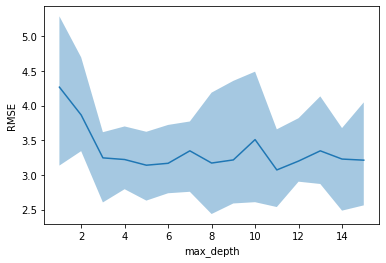

In [23]:
import numpy as np

from matplotlib import pyplot as plt


depths = range(1, 16)
rmse = {depth: [] for depth in depths}

for depth in depths:
    params = {
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "eval_metric": "rmse",
        "max_depth": depth,
        "tree_method": "hist"
    }

    for fold_index, (train_index, test_index) in enumerate(kf.split(y)):    
        xgtrain = DMatrix(X[train_index], label=y[train_index])
        xgtest = DMatrix(X[test_index], label=y[test_index])

        bst = xgb.train(params, xgtrain, num_boost_round=20)

        # print ("RMSE on fold {}: {}".format(fold_index, bst.eval(xgtest)))
        rmse[depth].append(to_float(bst.eval(xgtest)))

    rmse[depth] = [
        np.array(rmse[depth]).min(), 
        np.array(rmse[depth]).mean(), 
        np.array(rmse[depth]).max()
    ]

plt.xlabel('max_depth')
plt.ylabel('RMSE')
# plt.ylim(0, 10)
plt.plot(list(rmse.keys()), np.array(list(rmse.values()))[:, 1])
plt.fill_between(list(rmse.keys()), np.array(list(rmse.values()))[:, 0], np.array(list(rmse.values()))[:, 2], alpha=0.4)
plt.show()

In [10]:
np.array(list(rmse.values()))[:, 0]

array([4.027525, 3.126131, 2.517196, 2.843776, 2.668397, 2.591718,
       2.490582, 2.794047, 2.81437 , 2.884856, 2.933764, 2.808991,
       3.010733, 2.591069, 2.925564])

#### CatBoost

Аналогом для класса DMatrix в катбусте служит класс **catboost.Pool**. Помимо прочего, содержит индексы категориальных факторов и описание пар для режима попарного обучения.

[Подробнее](https://catboost.ai/docs/concepts/python-reference_pool.html)

**Задание 3. (0.5 балла)** Проделайте аналогичную работу используя CatBoost.

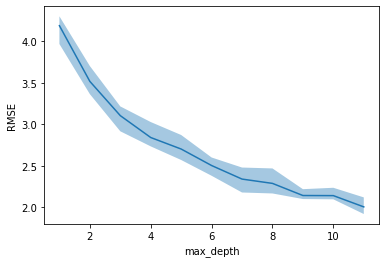

In [11]:
## YOUR CODE HERE

import numpy as np

from matplotlib import pyplot as plt


depths = range(1, 12)
rmse = {depth: [] for depth in depths}

for depth in depths:
    for fold_index, (train_index, test_index) in enumerate(kf.split(y)):    
        cbtrain = Pool(X[train_index], label=y[train_index])
        cbtest = Pool(X[test_index], label=y[test_index])

        cb_model = CatBoostRegressor(loss_function='RMSE', iterations=10, max_depth=depth, silent=True)
        cb_model.fit(cbtrain)

        # print("RMSE on fold {}: {}".format(fold_index, cb_model.best_score_['learn']['RMSE']))

        rmse[depth].append(cb_model.best_score_['learn']['RMSE'])

    rmse[depth] = [
        np.array(rmse[depth]).min(), 
        np.array(rmse[depth]).mean(), 
        np.array(rmse[depth]).max()
    ]


plt.xlabel('max_depth')
plt.ylabel('RMSE')
# plt.ylim(0, 5)
plt.plot(list(rmse.keys()), np.array(list(rmse.values()))[:, 1])
plt.fill_between(list(rmse.keys()), np.array(list(rmse.values()))[:, 0], np.array(list(rmse.values()))[:, 2], alpha=0.4)
plt.show()

###  Параллелизм

* По факторам;
* Есть возможность запускаться параллельно на CPU или на GPU

### Функции потерь и метрики качества

В обоих библиотеках встроено множество различных функций потерь.

XGBoost:

* reg:linear

* reg:logistic

* binary:logistic

* binary:logitraw

* multi:softmax

* rank:pairwise

* ...

[Метрики и функции потерь](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters)

CatBoost:
* RMSE

* LogLoss

* CrossEntropy

* MultiClass

* PairLogit

* PairLogitPairwise

* QueryRMSE

* ...

[Метрики и функции потерь](https://catboost.ai/docs/concepts/loss-functions.html#loss-functions__regression)

Метрики используются для ранней остановки обучения - обучение завершается, если значение метрики перестало улучшаться. 

В обеих моделях имеется возможность реализовать свои метрики и функции потерь.

### Визуализация

#### CatBoost

В CatBoost можно строить кривые обучения "из коробки":

In [12]:
from google.colab import output
output.enable_custom_widget_manager()

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.25)
X_validate, X_test, y_validate, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

In [14]:
cb = CatBoostRegressor(silent=True, eval_metric="MAE", custom_metric=["MAPE"])

In [15]:
cb.fit(X_train, y_train, eval_set=[(X_validate, y_validate), 
                                   (X_test, y_test)],
       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Построение деревьев

![text](https://qph.fs.quoracdn.net/main-qimg-5274e48e1766230e22e3cdd7e83019ce.webp)

#### XGBoost

По умолчанию деревья строятся слой за слоем (grow_policy="depthwise"). После достижения максимальной глубины (max_depth) происходит pruning - обрезание листьев, которые не дают прироста в качесте (отрицательный Gain).

При выборе grow_policy="lossguide" будет выбираться вершина и сплит для нее, которые максимально уменьшают функцию потерь. Это воспроизводит поведение в библиотеке lightGBM. В результате могут получиться перекошенные деревья (см. левый рисунок выше).

#### CatBoost

Деревья также строятся по *слоям*. При этом используются *oblivious decision trees*, то есть на каждом уровне дерева выбирается общий предикат для всех вершин.

Сплит выбирается из соображений наилучшего приближения вектора градиента.

### Бинаризация

Использовать все возможные значения каждого фактора для выбора сплита - очень накладно. Поэтому обычно значения фактора разбиваются на небольшое число корзин (бины). Существуют разные стратегии выбора бинов.

#### XGBoost

Задается параметром *tree_method*. Возможные значения:
  - **exact**. Используются всевозможные значения факторов;
  - **approx**. На каждой итерации бины пересчитываются (хитрым способом, в зависимости от значений градиента). Более того, можно пересчитывать локально для каждой вершины строящегося дерева. Параметр *sketch_eps* задает примерное кол-во бинов (число бинов ~ 1/sketch_eps);
  - **hist**. Гистограмма, которая считается один раз перед обучением - работает гораздо быстрее (8x-10x) без особой потери качества.

In [16]:
xgtrain = xgb.DMatrix(X_train, label=y_train)
xgvalidate = xgb.DMatrix(X_validate, label=y_validate)
xgtest = xgb.DMatrix(X_test, label=y_test)

In [17]:
for tree_method in ["exact", "approx", "hist"]:
    params = {
        "tree_method": tree_method,
        "sketch_eps": 0.2,
        "silent": True
    }
    bst = xgb.train(params, xgtrain, num_boost_round=100,)
    print ("binarization: {}\t, score: {}".format(tree_method, bst.eval(xgvalidate)))

binarization: exact	, score: [0]	eval-rmse:2.816570
binarization: approx	, score: [0]	eval-rmse:3.839222
binarization: hist	, score: [0]	eval-rmse:2.488727


#### CatBoost

 Выбрать стратегию бинаризации можно установив параметр *feature_border_type*.
 
  - **Uniform**. Границы выбираются равномерно по значениям;
  - **Median**. В каждый бин попадает примерно одинаковое число различных значений;
  - **UniformAndQuantiles**. Uniform + Median;
  - **MaxLogSum, GreedyLogSum**. Максимизируется значение формулы $\sum_{i=1}^K \log(n_i)$, где $K$ - требуемое кол-во бинов, $n_i$ число объектов в этом бакете;
  - **MinEntropy**. Аналогично, но максимизируется энтропия: $-\sum_{i=1}^K n_i \log(n_i)$

**Задание 4. (0.5 балла)** Для каждого варианта стратегии бинаризации выведите MSE, который получается :)

In [18]:
### YOUR CODE HERE

cbtrain = Pool(X_train, label=y_train)
cbvalidate = Pool(X_validate, label=y_validate)
cbtest = Pool(X_test, label=y_test)

for border_type in ["Uniform", "Median", "UniformAndQuantiles", "MaxLogSum", "GreedyLogSum", "MinEntropy"]:
    cb_model = CatBoostRegressor(loss_function='RMSE', silent=True, feature_border_type=border_type)
    cb_model.fit(cbtrain)
    print("binarization: {:20}, score: {}".format(border_type, cb_model.best_score_))


binarization: Uniform             , score: {'learn': {'RMSE': 0.5249885546840776}}
binarization: Median              , score: {'learn': {'RMSE': 0.47136129167845714}}
binarization: UniformAndQuantiles , score: {'learn': {'RMSE': 0.4836076961644082}}
binarization: MaxLogSum           , score: {'learn': {'RMSE': 0.45838520494107793}}
binarization: GreedyLogSum        , score: {'learn': {'RMSE': 0.4655395347841914}}
binarization: MinEntropy          , score: {'learn': {'RMSE': 0.4616346156260314}}


### Пропущенные значения

#### XGBoost

  * Есть возможность явно заменять пропущенные значения на фиксированное число (параметр *missing* при создании *DMatrix*).

#### CatBoost

За политику обработки пропущенных значений отвечает параметр *nan_mode*. Возможные значения:
  * **Min/Max** - пропуски отправляются либо всегда в левую ветку, либо всегда в правую;
  * **Forbidden** - заметив NaN, модель начинает неистово истерить, брызжа исключениями во все стороны.

### Важности фичей

#### XGBoost

In [19]:
from collections import Counter
params = {
    "objective": "reg:linear",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "max_depth": 6,
    "tree_method": "hist",
    "silent": True
}

bst = xgb.train(params, DMatrix(X_train, y_train, feature_names=boston['feature_names']), num_boost_round=100)

fstrs = bst.get_fscore()

for name, value in Counter(bst.get_fscore()).most_common():
    print ("{}\t{}".format(name, value))

CRIM	789
RM	503
AGE	359
LSTAT	357
B	330
DIS	307
NOX	199
INDUS	103
PTRATIO	88
TAX	85
ZN	58
RAD	40
CHAS	21


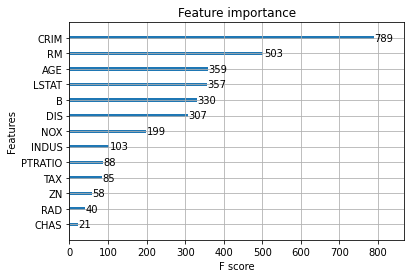

In [20]:
xgb.plot_importance(bst)

#### CatBoost

**Задание 5. (1 балл)** И, традиционно, проделайте аналогичную работу над CatBoost'ом :)

In [21]:
### YOUR CODE HERE

from collections import Counter

cbtrain = Pool(X_train, label=y_train)

cb_model = CatBoostRegressor(loss_function='RMSE', silent=True, feature_border_type=border_type)
cb_model.fit(cbtrain)

fstrs = cb_model.get_feature_importance(prettified=True)

print(fstrs)

   Feature Id  Importances
0          12    32.899541
1           5    27.631292
2           7     7.618785
3           4     5.803601
4          10     4.822308
5           0     4.659242
6          11     4.241373
7           6     3.073105
8           9     2.880932
9           8     2.115167
10          2     2.098040
11          3     1.550022
12          1     0.606594


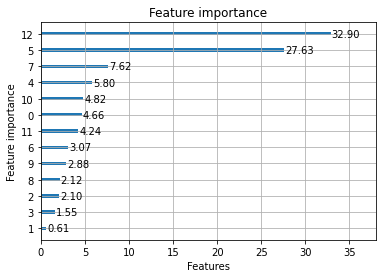

In [22]:
plt.barh(fstrs['Feature Id'].iloc[::-1], fstrs['Importances'].iloc[::-1], height=0.2)
for i, v in enumerate(fstrs['Importances'].iloc[::-1]):
    plt.text(v + 0.1, i - 0.2, '{:.2f}'.format(v))
plt.title('Feature importance')
plt.xlabel('Features')
plt.ylabel('Feature importance')
plt.xlim(0, 38)
plt.grid()
plt.show()